Link do notebook no colab
https://colab.research.google.com/drive/1L4QQu7KjOZUos1WkzoO3-ZYlwSZTzmel

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def trimf(x, a, b, c):
  x = np.asarray(x, dtype=float)
  esquerda= (x -a)/ (b - a + 0.0000000001 )   # 180
  direita = (c - x)/ ( c - b +1e-10 )    # -10
  return np.maximum( 0, np.minimum(esquerda,direita))

## trapezoidal
def trapmf(x, a, b, c, d):
  x = np.asarray(x, dtype=float)
  subida = (x - a)/ (b - a + 1e-10) # coeficiente angular 1/(b-a
  descida = (d - x)/ (d - c + 1e-10) # coeficiente angular -1/(d-c)
  return np.maximum( 0 ,  np.minimum(    np.minimum(  subida , descida )   ,   1)   )

def plot_mf(universo, mfs: dict, title="Funções de pertinencia"):
  plt.figure(figsize=(6,3))
  for name, mf in mfs.items():
    plt.plot(universo, mf, label=name)
  plt.ylim(-0.05, 1.05)
  plt.title(title)
  plt.xlabel("Universo")
  plt.ylabel("μ")
  plt.legend()
  plt.grid(alpha=0.25)
  plt.show()

def centroid(x, mu):
  x= np.asarray(x, dtype=float)
  mu= np.asarray(mu, dtype=float)
  num = np.trapezoid(x*mu, x)
  den= np.trapezoid(mu, x)
  return num/den


In [3]:

data = [
    [22, 2200, 1], [24, 2500, 1], [26, 3000, 0], [28, 2800, 0], [30, 3200, 0],
    [32, 3800, 0], [35, 4200, 0], [37, 4500, 0], [40, 4800, 0], [42, 5200, 0],
    [45, 5500, 0], [48, 6000, 0], [51, 6500, 0], [55, 7000, 0], [60, 8000, 0],
    [23, 1800, 1], [27, 2100, 1], [29, 2600, 1], [33, 3100, 0], [36, 3400, 0]
]

In [4]:
df =  pd.DataFrame(data, columns=["idade", "salario", "inad"])
df.head()

,idade,salario,inad
0,22,2200,1
1,24,2500,1
2,26,3000,0
3,28,2800,0
4,30,3200,0


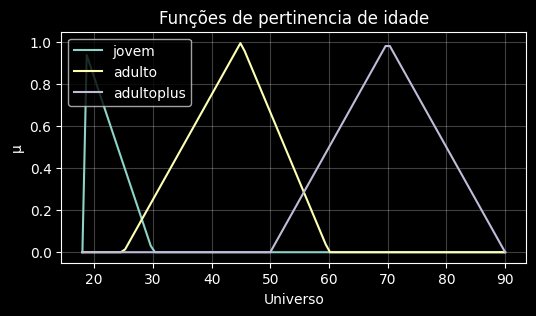

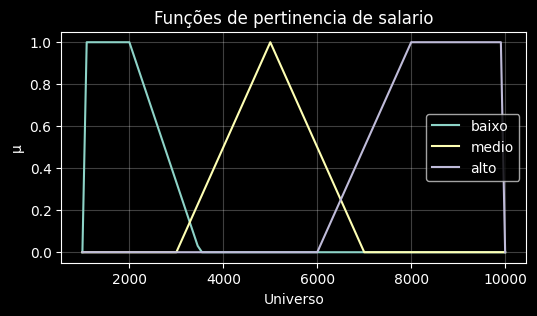

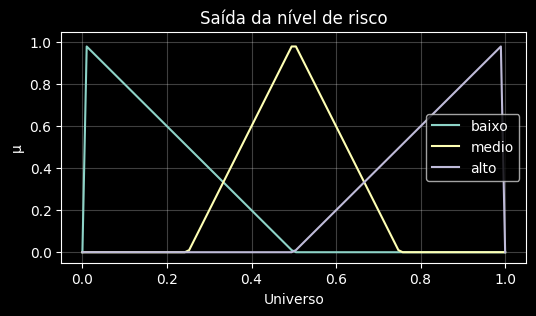

In [5]:
idade_a, idade_b , idade_c = 18, 18, 30
idade_d, idade_e , idade_f = 25, 45, 60
idade_g, idade_h , idade_i = 50, 70, 90


salario_a, salario_b , salario_c, salario_d = 1000, 1000, 2000, 3500
salario_e, salario_f , salario_g = 3000, 5000, 7000
salario_h, salario_i , salario_j, salario_k = 6000, 8000, 10000,10000

U_idade = np.linspace(idade_a, idade_i, 100)
U_salario = np.linspace(salario_a, salario_k, 100)
U_risco = np.linspace(0, 1, 100)

idade_mfs = {
    "jovem": trimf(U_idade, idade_a, idade_b, idade_c),
    "adulto": trimf(U_idade, idade_d, idade_e, idade_f),
    "adultoplus": trimf(U_idade, idade_g, idade_h, idade_i)
}

sal_mfs = {
    "baixo": trapmf(U_salario, salario_a, salario_b, salario_c, salario_d),
    "medio": trimf(U_salario, salario_e, salario_f, salario_g),
    "alto": trapmf(U_salario, salario_h, salario_i, salario_j, salario_k)
}




risco_mfs = { 'baixo': trimf(U_risco, 0, 0, 0.5), 'medio': trimf(U_risco, .25, 0.5, 0.75), 'alto': trimf(U_risco, .5, 1, 1) }

plot_mf(U_idade, idade_mfs, title="Funções de pertinencia de idade")
plot_mf(U_salario, sal_mfs, title="Funções de pertinencia de salario")
plot_mf(U_risco, risco_mfs, title="Saída da nível de risco")

In [6]:
def risco_mamdani(muidade, musal):

  regras= [
      ('alto', min( musal['baixo'], muidade['jovem']  )),
      ('alto', min( musal['medio'], muidade['jovem'] )),
      ('medio', min( musal['alto'], muidade['jovem'] )),

      ('medio', min( musal['baixo'], muidade['adulto'] )),
      ('medio', min( musal['medio'], muidade['adulto'] )),
      ('baixo', min( musal['alto'], muidade['adulto'] )),


      ('medio', min( musal['baixo'], muidade['adultoplus'] )),
      ('baixo', min( musal['medio'], muidade['adultoplus'] )),
      ('baixo', min( musal['alto'], muidade['adultoplus'] )),
  ]
  agg = np.zeros_like(U_risco)
  for label, alpha in regras:
    agg = np.maximum(agg, np.minimum(risco_mfs[label] , alpha))
  y = centroid(U_risco, agg)
  return y, agg

def fuzzify_lin(linha):
  idade, salario = float(linha['idade']), float(linha['salario'])

  muidade = { k : float(np.interp(idade, U_idade,y ) ) for k,y in idade_mfs.items()}
  musal = { k : float(np.interp(salario, U_salario,y ) ) for k,y in sal_mfs.items()}

  return muidade, musal

In [7]:
muidade, musal = fuzzify_lin(df.iloc[3])
muidade, musal

({'jovem': 0.16666666666527777, 'adulto': 0.14999999999925, 'adultoplus': 0.0},
 {'baixo': 0.46666666666663553, 'medio': 0.0, 'alto': 0.0})

In [8]:
linhas = []

for i, linha in df.iterrows():
  muidade, musal = fuzzify_lin(linha)
  y, _ = risco_mamdani(muidade, musal)
  linhas.append({'risco': y})

df_eval = pd.concat([df, pd.DataFrame(linhas)], axis=1)
df_eval.head()

,idade,salario,inad,risco
0,22,2200,1,0.816680
1,24,2500,1,0.802911
2,26,3000,0,0.751892
3,28,2800,0,0.641093
4,30,3200,0,0.514783


([<matplotlib.axis.XTick at 0x189ab0034d0>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

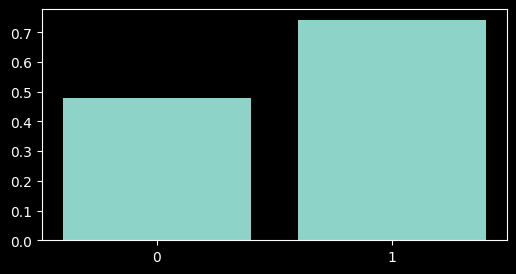

In [9]:
gm = df_eval.groupby('inad').mean()


plt.figure(figsize=(6,3))
plt.bar(gm.index, gm['risco'])
plt.xticks(gm.index)

In [10]:
df.head(1)

,idade,salario,inad
0,22,2200,1


Risco: 0.8166796166888132


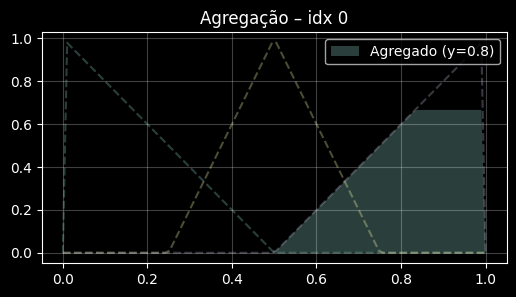

Risco: 0.7518920077276463


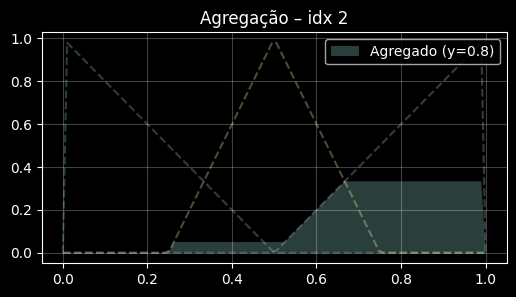

Risco: 0.6410933967561381


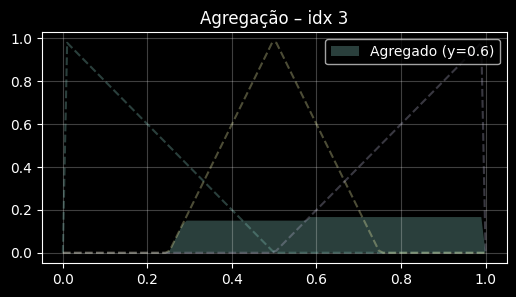

Risco: 0.5


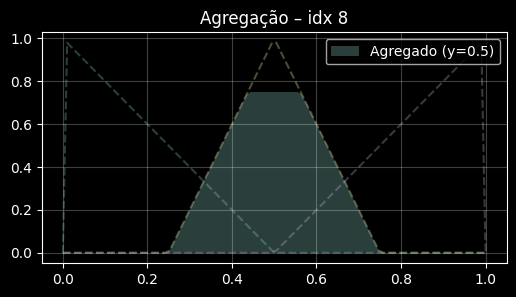

Risco: 0.36218387418546316


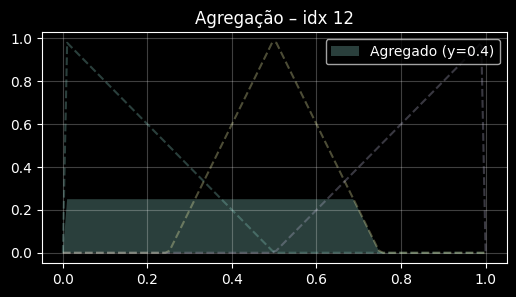

In [11]:
idx_list = [0,2,3,8,12]
for idx in idx_list :
  linha =df.loc[idx]
  muidade, musal = fuzzify_lin(linha)
  y, agg = risco_mamdani(muidade, musal)
  print(f"Risco: {y}")

  plt.figure(figsize=(6,3))
  for n, y_mf in risco_mfs.items(): plt.plot(U_risco, y_mf, '--', alpha = 0.3)
  plt.fill_between(U_risco, 0, agg, alpha=0.3, label=f'Agregado (y={y:.1f})')
  plt.legend(); plt.grid(alpha=0.25); plt.title(f'Agregação – idx {idx}'); plt.show()
  #plt.ylim(-0.05, 1.05)
#data = [
#    [22, 2200, 1], [24, 2500, 1], [26, 3000, 0], [28, 2800, 0], [30, 3200, 0],
#   [32, 3800, 0], [35, 4200, 0], [37, 4500, 0], [40, 4800, 0], [42, 5200, 0],
 #   [45, 5500, 0], [48, 6000, 0], [51, 6500, 0], [55, 7000, 0], [60, 8000, 0],
  #  [23, 1800, 1], [27, 2100, 1], [29, 2600, 1], [33, 3100, 0], [36, 3400, 0]
#]

In [12]:
def predict_nitido(linha):
  return int((linha['salario']< 4000) or (linha['idade']< 25))

def confusao(y_true, y_pred):
  y_true = np.asarray(y_true)
  y_pred = np.asarray(y_pred)

  tp= int(np.sum((y_true == 1) & (y_pred == 1)))
  tn= int(np.sum((y_true == 0) & (y_pred == 0)))
  fp = int(np.sum((y_true == 0) & (y_pred == 1)))
  fn = int(np.sum((y_true == 1) & (y_pred == 0)))
  acc = (tp+tn)/(tp+tn+fp+fn)
  return tp, tn, fp, fn,acc



In [13]:
df_eval['pred_nitido'] = df_eval.apply(predict_nitido, axis=1)


df_eval.head()

c_nitida = confusao(df_eval['inad'], df_eval['pred_nitido'])

c_fuzzy = confusao(df_eval['inad'], df_eval['risco'] > 0.55)



print('Nitido: ', c_nitida)
print('Fuzzy: ', c_fuzzy)


Nitido:  (5, 9, 6, 0, 0.7)
Fuzzy:  (5, 13, 2, 0, 0.9)
